In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing
from tqdm.auto import tqdm
from pdet import MZQbin, alphaBayesCI_map, RateRatioBayesCI_map, _bin_initializer_worker

/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [2]:
minf, msup = 8, 13
zw = 0.005 # Width of redshift bins
zref = 0.2 # Reference redshift (inferior limit of reference redshift bin)
q = 0.5 # # q = m2 / m1, with m2 <= m1

bin2_ref = MZQbin(minf, msup, zref, zref + zw, q)
N2_ref = 60

T_obs = 1

zinf_axis = np.arange(0, 0.45, zw) # Inferior limits of map's redshift bins
bins_axis = [MZQbin(minf, msup, zinf, zinf + zw, q) for zinf in zinf_axis]
R1_R2_axis = np.arange(0.01, 5, 0.01)

N1_N2_axis = np.arange(0.01, 10, 0.01)

cl = 0.95

In [3]:
# Bin initializer: Computes and saves VT
def bin_initializer(bin_list, T_obs, mcn=100000):
    args = [(i, bin, T_obs, mcn) for i, bin in enumerate(bins_axis)]

    # Use unordered multiprocessing to initialize bins
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = list(tqdm(pool.imap_unordered(_bin_initializer_worker, args), total=len(args),
                            desc='Initilizing bins: computing VT'))
        
    # Reorder and return the results
    for i, bin in results:
        bin_list[i] = bin

    return bin_list

In [4]:
# Initialize the bins before using mapping functions!!
bin2_ref.VTmc(T_obs)
if __name__ == '__main__':
    bin_initializer(bins_axis, T_obs)

Initilizing bins: computing VT:   0%|          | 0/90 [00:00<?, ?it/s]/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resource

In [5]:
alpha_CI_map = alphaBayesCI_map(cl, bin2_ref, R1_R2_axis, bins_axis, N2_ref, T_obs)

Computing number of events ratio map: 100%|██████████| 44910/44910 [00:22<00:00, 1976.19it/s]


In [6]:
R1_R2_CI_map = RateRatioBayesCI_map(cl, bin2_ref, N1_N2_axis, bins_axis, N2_ref, T_obs)

Computing rate ratio map: 100%|██████████| 89910/89910 [00:43<00:00, 2089.68it/s]


In [7]:
alpha_CI_array = np.zeros((len(R1_R2_axis), len(bins_axis), 3))
alpha_a_array = np.zeros((len(R1_R2_axis), len(bins_axis)))

N1_N2_ref = 2
# 1 if R1_R2_ref is inside confidence interval
Det_map_alpha = np.zeros((len(R1_R2_axis), len(bins_axis)))

# Fill the arrays
for i, _ in enumerate(R1_R2_axis):
    for j, _ in enumerate(bins_axis):
        alpha_CI_array[i, j] = np.copy(alpha_CI_map[i][j][0])
        alpha_a_array[i, j] = alpha_CI_map[i][j][2] # a = bin2_ref.VT / bin.VT
        
        if alpha_CI_map[i][j][0][0] <= N1_N2_ref <= alpha_CI_map[i][j][0][2]:
            Det_map_alpha[i, j] = 1

In [8]:
print(np.min(alpha_CI_array[:, :, 1]), np.max(alpha_CI_array[:, :, 1]))
print(np.min(alpha_a_array), np.max(alpha_a_array))

0.003782509569348432 6.765269939279863
0.7358446308002532 1610705.0472573985


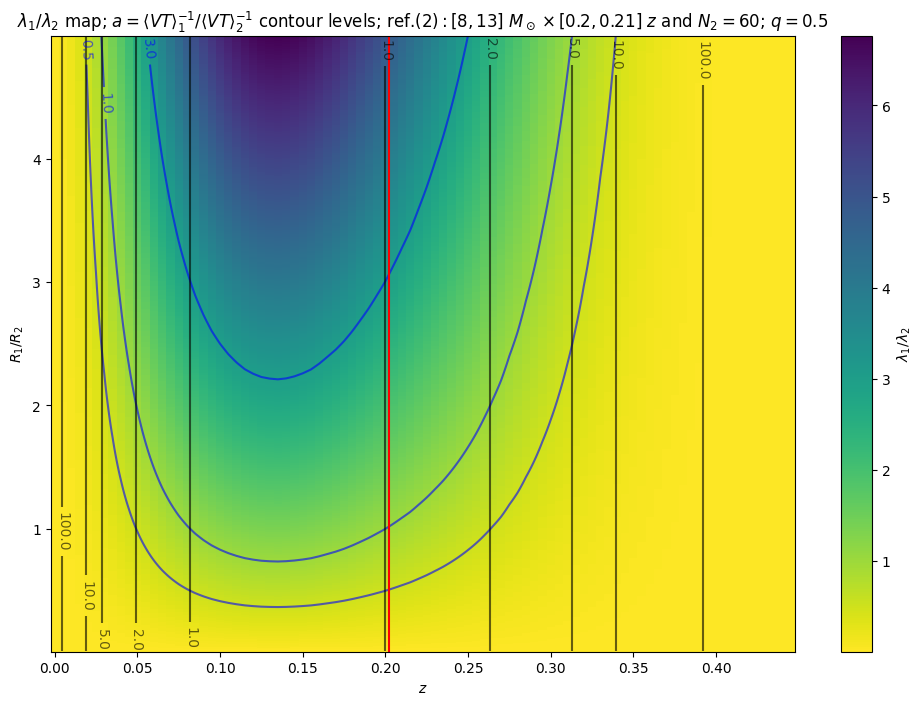

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$\lambda_1 / \lambda_2$ map; $a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}}$ contour levels; $\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {5}$'.format(bin2_ref.minf,
                                                                                                                                                                                                                     bin2_ref.msup,
                                                                                                                                                                                                                     bin2_ref.zinf,
                                                                                                                                                                                                                     np.format_float_positional(bin2_ref.zsup, 2),
                                                                                                                                                                                                                     N2_ref,
                                                                                                                                                                                                                     q))
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$R_1 / R_2$')

# lambda_1 / lamba_2 color map and few contour levels
cmap = plt.colormaps['viridis_r']
im = ax.pcolormesh(zinf_axis, R1_R2_axis, alpha_CI_array[:, :, 1],
                   cmap=cmap)
fig.colorbar(im, ax=ax, label=r'$\lambda_1 / \lambda_2$')

# N1/N2 Contour levels
cf = ax.contour(zinf_axis, R1_R2_axis, alpha_CI_array[:, :, 1],
                levels=[0.5, 1, 3], colors='blue', alpha=0.6)
ax.clabel(cf)

# a contour levels
cf = ax.contour(zinf_axis, R1_R2_axis, alpha_a_array,
                levels=[0.5, 1, 2, 5, 10, 100], colors='black', alpha=0.6)
ax.clabel(cf)

# Reference line for the reference bin
ax.axvline((bin2_ref.zinf + bin2_ref.zsup) / 2, color='red')

plt.show()

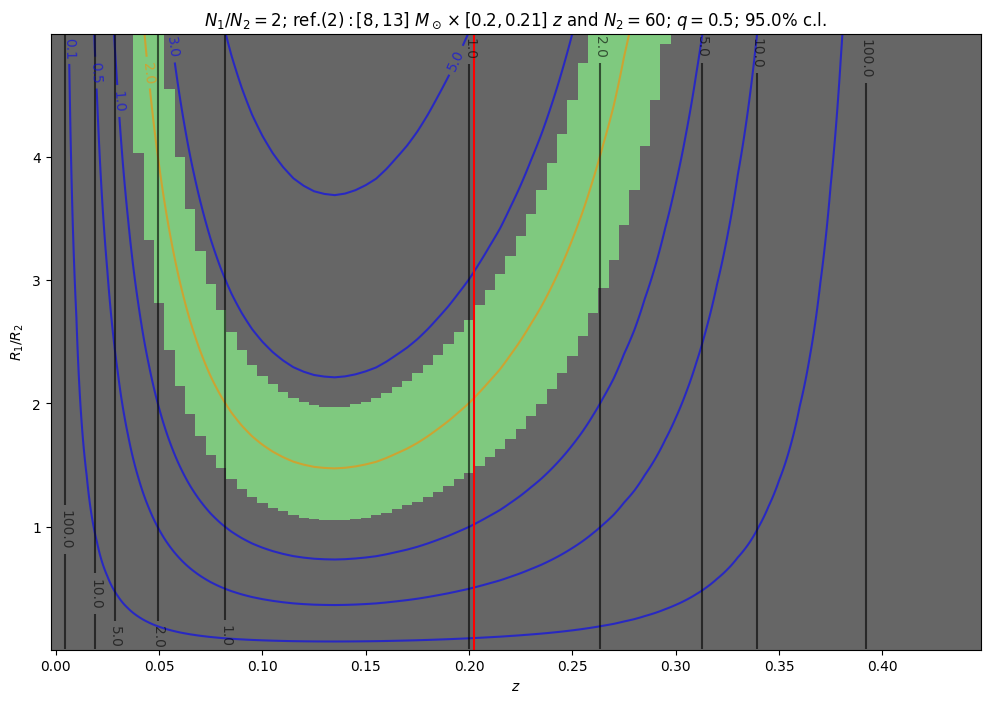

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$N_1 / N_2 = {5}$; $\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {6}$; {7}% c.l.'.format(bin2_ref.minf,
                                                                                                                       bin2_ref.msup,
                                                                                                                       bin2_ref.zinf,
                                                                                                                       np.format_float_positional(bin2_ref.zsup, 2),
                                                                                                                       N2_ref,
                                                                                                                       N1_N2_ref,
                                                                                                                       q,
                                                                                                                       cl * 100))
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$R_1 / R_2$')

# lambda_1 / lamba_2 color map and few contour levels
cmap = plt.colormaps['Accent_r']
im = ax.pcolormesh(zinf_axis, R1_R2_axis, Det_map_alpha,
                   cmap=cmap)

# N1/N2 Contour levels
levels = list(dict.fromkeys(sorted([0.1, 0.5, 1, 3, 5, 10, N1_N2_ref]))) # To avoid duplicates
colors = ['blue'] * (len(levels))
colors[levels.index(N1_N2_ref)] = 'darkorange'
cf = ax.contour(zinf_axis, R1_R2_axis, alpha_CI_array[:, :, 1],
                levels=levels, colors=colors, alpha=0.6)
ax.clabel(cf)

# a contour levels
cf = ax.contour(zinf_axis, R1_R2_axis, alpha_a_array,
                levels=[0.5, 1, 2, 5, 10, 100], colors='black', alpha=0.6)
ax.clabel(cf)

# Reference line for the reference bin
ax.axvline((bin2_ref.zinf + bin2_ref.zsup) / 2, color='red')

plt.show()

In [11]:
R1_R2_CI_array = np.zeros((len(N1_N2_axis), len(bins_axis), 3))
R1_R2_a_array = np.zeros((len(N1_N2_axis), len(bins_axis)))

R1_R2_ref = 2
# 1 if R1_R2_ref is inside confidence interval
Det_map_R1_R2 = np.zeros((len(N1_N2_axis), len(bins_axis)))

R1_R2_ref_list = [0.5, 1, 2, 3, 5, 10]
# Linked to R1_R2_ref_list on the first dimension. True if the corresponding R1_R2 value is inside the confidence interval
R1_R2_CI_list_mask = np.zeros((len(R1_R2_ref_list), len(N1_N2_axis), len(bins_axis)), dtype=bool)

# Fill the arrays
for i, _ in enumerate(N1_N2_axis):
    for j, _ in enumerate(bins_axis):
        R1_R2_CI_array[i, j] = np.copy(R1_R2_CI_map[i][j][0])
        R1_R2_a_array[i, j] = R1_R2_CI_map[i][j][2] # a = bin2_ref.VT / bin.VT

        if R1_R2_CI_map[i][j][0][0] <= R1_R2_ref <= R1_R2_CI_map[i][j][0][2]:
            Det_map_R1_R2[i, j] = 1
            
        for k, R1_R2 in enumerate(R1_R2_ref_list):
            if R1_R2_CI_map[i][j][0][0] <= R1_R2 <= R1_R2_CI_map[i][j][0][2]:
                R1_R2_CI_list_mask[k, i, j] = True

# For each value in R1_R2_ref_list, select the N1_N2 vs z curves that represents the associated confidence interval
inf_lvl_alpha = np.zeros((len(R1_R2_ref_list), len(bins_axis)))
sup_lvl_alpha = np.zeros((len(R1_R2_ref_list), len(bins_axis)))

for i in range(len(R1_R2_ref_list)):
    for j in range(len(bins_axis)):
        True_indexes = np.where(R1_R2_CI_list_mask[i, :, j])[0]
        if len(True_indexes) != 0:
            inf_lvl_alpha[i, j] = N1_N2_axis[True_indexes[0]]
            sup_lvl_alpha[i, j] = N1_N2_axis[True_indexes[-1]]

In [12]:
print(np.min(R1_R2_CI_array[:, :, 1]), np.max(R1_R2_CI_array[:, :, 1]))
print(np.min(R1_R2_a_array), np.max(R1_R2_a_array))

0.009666939829384746 16050741.619261293
0.7358446308002532 1610705.0472573985


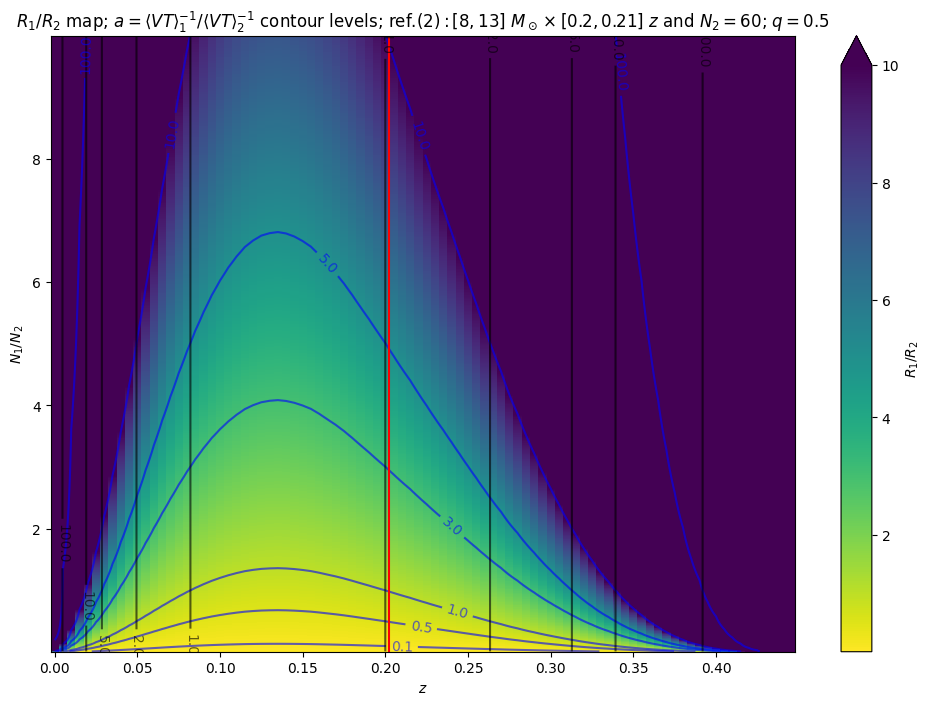

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$R_1 / R_2$ map; $a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}}$ contour levels; $\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {5}$'.format(bin2_ref.minf,
                                                                                                                                                                                                                     bin2_ref.msup,
                                                                                                                                                                                                                     bin2_ref.zinf,
                                                                                                                                                                                                                     np.format_float_positional(bin2_ref.zsup, 2),
                                                                                                                                                                                                                     N2_ref,
                                                                                                                                                                                                                     q))
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$N_1 / N_2$')

# lambda_1 / lamba_2 color map and few contour levels
cmap = plt.colormaps['viridis_r']
im = ax.pcolormesh(zinf_axis, N1_N2_axis, R1_R2_CI_array[:, :, 1],
                   cmap=cmap, norm=mpl.colors.Normalize(vmin=np.min(R1_R2_CI_array[:, :, 1]), vmax=10))
fig.colorbar(im, ax=ax, label=r'$R_1 / R_2$', extend='max')

# R1/R2 Contour levels
cf = ax.contour(zinf_axis, N1_N2_axis, R1_R2_CI_array[:, :, 1],
                levels=[0.1, 0.5, 1, 3, 5, 10, 100], colors='blue', alpha=0.6)
ax.clabel(cf)

# a contour levels
cf = ax.contour(zinf_axis, N1_N2_axis, R1_R2_a_array,
                levels=[0.5, 1, 2, 5, 10, 100], colors='black', alpha=0.6)
ax.clabel(cf)

# Reference line for the reference bin
ax.axvline((bin2_ref.zinf + bin2_ref.zsup) / 2, color='red')

plt.show()

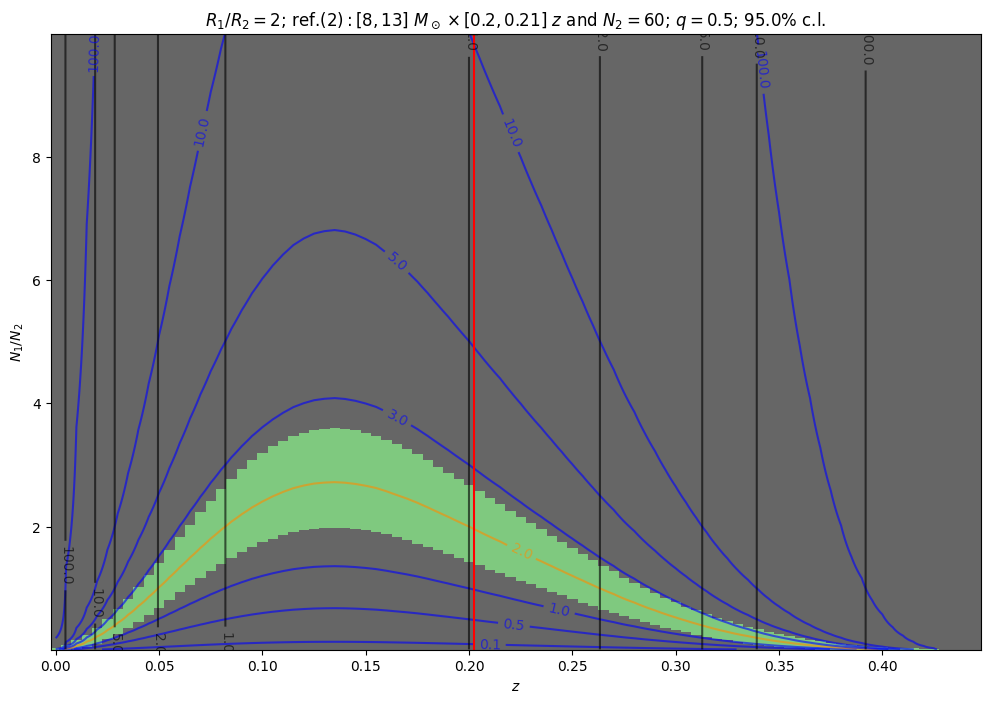

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$R_1 / R_2 = {5}$; $\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {6}$; {7}% c.l.'.format(bin2_ref.minf,
                                                                                                                       bin2_ref.msup,
                                                                                                                       bin2_ref.zinf,
                                                                                                                       np.format_float_positional(bin2_ref.zsup, 2),
                                                                                                                       N2_ref,
                                                                                                                       R1_R2_ref,
                                                                                                                       q,
                                                                                                                       cl * 100))
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$N_1 / N_2$')

# lambda_1 / lamba_2 color map
cmap = plt.colormaps['Accent_r']
im = ax.pcolormesh(zinf_axis, N1_N2_axis, Det_map_R1_R2,
                   cmap=cmap)

# R1/R2 Contour levels
levels = list(dict.fromkeys(sorted([0.1, 0.5, 1, 3, 5, 10, 100, R1_R2_ref]))) # To avoid duplicates
colors = ['blue'] * (len(levels))
colors[levels.index(R1_R2_ref)] = 'darkorange'
cf = ax.contour(zinf_axis, N1_N2_axis, R1_R2_CI_array[:, :, 1],
                levels=levels, colors=colors, alpha=0.6)
ax.clabel(cf)

# a contour levels
cf = ax.contour(zinf_axis, N1_N2_axis, R1_R2_a_array,
                levels=[0.5, 1, 2, 5, 10, 100], colors='black', alpha=0.6)
ax.clabel(cf)

# Reference line for the reference bin
ax.axvline((bin2_ref.zinf + bin2_ref.zsup) / 2, color='red')

plt.show()

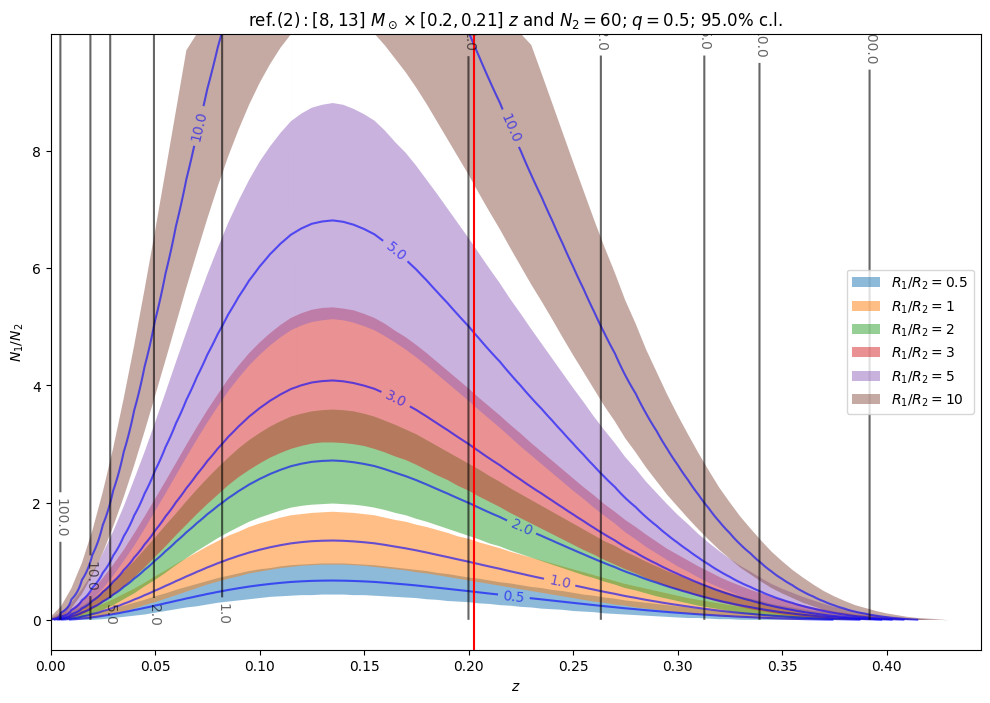

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {5}$; {6}% c.l.'.format(bin2_ref.minf,
                                                                                                                       bin2_ref.msup,
                                                                                                                       bin2_ref.zinf,
                                                                                                                       np.format_float_positional(bin2_ref.zsup, 2),
                                                                                                                       N2_ref,
                                                                                                                       q,
                                                                                                                       cl * 100))

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$N_1 / N_2$')

# R_1 / R_2 confidence intervals for multiple values of R1_R2_ref and 
for inf, sup, lb in zip(inf_lvl_alpha, sup_lvl_alpha, R1_R2_ref_list):
    ax.fill_between(zinf_axis, inf, sup, alpha=0.5,
                    label=r'$R_1 / R_2 = {0}$'.format(lb))

# R1/R2 Contour levels
cf = ax.contour(zinf_axis, N1_N2_axis, R1_R2_CI_array[:, :, 1],
                levels=R1_R2_ref_list, colors='blue', alpha=0.6)
ax.clabel(cf)

# a contour levels
cf = ax.contour(zinf_axis, N1_N2_axis, R1_R2_a_array,
                levels=[0.5, 1, 2, 5, 10, 100], colors='black', alpha=0.6)
ax.clabel(cf)

# Reference line for the reference bin
ax.axvline((bin2_ref.zinf + bin2_ref.zsup) / 2, color='red')

ax.legend()

plt.show()